## Sentiment Analyser


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from fastai.text import *
import html

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/aclImdb/')

## Data

In [3]:
CLAS_PATH=Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

The imdb dataset has 3 classes. positive, negative and unsupervised(sentiment is unknown). 
There are 75k training reviews(12.5k pos, 12.5k neg, 50k unsup)
There are 25k validation reviews(12.5k pos, 12.5k neg & no unsup)

Refer to the README file in the imdb corpus for further information about the dataset.

In [4]:
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r',encoding="utf8").read())
            labels.append(idx)
    return np.array(texts),np.array(labels)

trn_texts,trn_labels = get_texts(PATH/'train')
val_texts,val_labels = get_texts(PATH/'test')

In [5]:
len(trn_texts),len(val_texts)

(75000, 25000)

In [6]:
col_names = ['labels','text']

In [7]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [8]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [9]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [10]:
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train10.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test10.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

In [11]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

In [12]:
len(trn_texts), len(val_texts)

(90000, 10000)

In [13]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train10.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test10.csv', header=False, index=False)

## Language model tokens

In [38]:
chunksize=24000

In [39]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [40]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [41]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [18]:
df_trn = pd.read_csv(LM_PATH/'train10.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test10.csv', header=None, chunksize=chunksize)

In [19]:
type(df_trn)

pandas.io.parsers.TextFileReader

In [20]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
0


In [21]:
tok_trn = tok_trn[:10000]
tok_val = tok_val[:10000]

In [22]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [23]:
np.save(LM_PATH/'tmp'/'tok_trn10.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val10.npy', tok_val)

In [4]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn10.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val10.npy')

In [5]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 135943),
 ('.', 111953),
 (',', 111513),
 ('and', 66236),
 ('a', 65055),
 ('of', 59048),
 ('to', 54907),
 ('is', 43749),
 ('it', 38550),
 ('in', 37929),
 ('i', 35418),
 ('this', 30515),
 ('that', 29553),
 ('"', 26758),
 ("'s", 24552),
 ('-', 20660),
 ('was', 20534),
 ('\n\n', 20153),
 ('as', 18642),
 ('for', 18071),
 ('with', 17898),
 ('movie', 17674),
 ('but', 16805),
 ('film', 16091),
 ('you', 13846)]

In [6]:
max_vocab = 10000
min_freq = 5

In [7]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [8]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

10002

In [29]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [30]:
np.save(LM_PATH/'tmp'/'trn_ids10.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids10.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos10.pkl', 'wb'))

In [9]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids10.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids10.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos10.pkl', 'rb'))

In [10]:
vs=len(itos)
vs,len(trn_lm)

(10002, 10000)

## Building a language model for wikitext

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target IMDB LM so that the weights can be loaded up.

In [11]:
em_sz,nh,nl = 400,1150,3

In [12]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [11]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [12]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [13]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [14]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [15]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language model

In [14]:
wd=1e-7
bptt=30
bs=32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [15]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [16]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [17]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [18]:
lr=1e-3
lrs = lr

In [21]:
learner.unfreeze()

In [25]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.58884    4.478175   0.235656  



[4.478175335056077, 0.2356563435554835]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [27]:
learner.save('lm110')
learner.save_encoder('lm1_enc10')

In [27]:
learner.load('lm110')
learner.load_encoder('lm1_enc10')

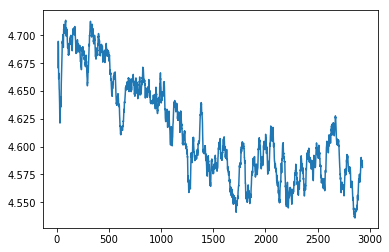

In [29]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone.

In [31]:
df_trn = pd.read_csv(CLAS_PATH/'train10.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test10.csv', header=None, chunksize=chunksize)

In [32]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0
1


In [33]:
tok_trn, trn_labels = tok_trn[:10000], trn_labels[:10000]
tok_val, val_labels = tok_val[:10000], val_labels[:10000]

In [34]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn10.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val10.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels10.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels10.npy', val_labels)

In [19]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn10.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val10.npy')

In [20]:
itos = pickle.load((LM_PATH/'tmp'/'itos10.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

10002

In [37]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [38]:
np.save(CLAS_PATH/'tmp'/'trn_ids10.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids10.npy', val_clas)

## Classifier

In [21]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids10.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids10.npy')

In [22]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels10.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels10.npy'))

In [23]:
bptt,em_sz,nh,nl = 30,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 32

In [24]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [25]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [26]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [27]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [28]:
m = get_rnn_classifier(bptt, 20*30, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 20, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [29]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [30]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [31]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [32]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [33]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc10')

In [48]:
learn.freeze_to(-1)

 89%|███████████████████████████████████████████████████████████████        | 56/63 [02:28<00:18,  2.65s/it, loss=1.71]

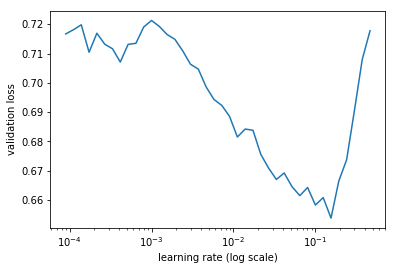

In [22]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [53]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.561838   0.558663   0.712     



[0.5586627355575562, 0.712]

In [54]:
learn.save('clas_10')

In [49]:
learn.load('clas_10')

In [50]:
learn.freeze_to(-2)

In [51]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.461224   0.433957   0.8014    



[0.43395660662651064, 0.8014]

In [183]:
learn.save('clas_110')

In [43]:
learn.load('clas_110')

In [20]:
learn.unfreeze()

In [21]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                      
    0      0.337347   0.186812   0.930782  
    1      0.284065   0.318038   0.932062                      
    2      0.246721   0.156018   0.941747                      
    3      0.252745   0.157223   0.944106                      
    4      0.24023    0.159444   0.945393                      
    5      0.210046   0.202856   0.942858                      
    6      0.212139   0.149009   0.943746                      
    7      0.21163    0.186739   0.946553                      
    8      0.186233   0.1508     0.945218                      
    9      0.176225   0.150472   0.947985                      
    10     0.198024   0.146215   0.948345                      
    11     0.20324    0.189206   0.948145                      
    12     0.165159   0.151402   0.947745                      
    13     0.165997   0.146615   0.947905                      



[0.14661488, 0.9479046703071374]

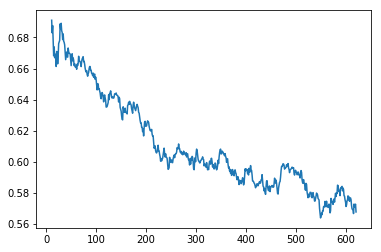

In [56]:
learn.sched.plot_loss()

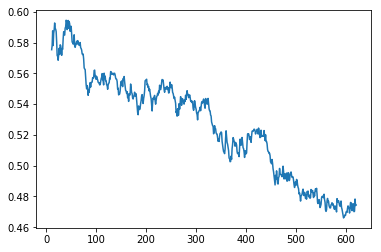

In [91]:
learn.sched.plot_loss()

### Getting sentiments from cisco comments

In [44]:
import math
def get_sentiment(model,comment,trn = False):
    s = comment
    
    if not trn:
        s = fixup(comment)
        s = [stoi[w] for w in s.split()]
    
    t = np.array([s]).T
    res = m(V(t))[0][0].cpu().data.numpy() 
    p = math.exp(res[1])/(math.exp(res[0])+math.exp(res[1]))
    p = 0.70*p 
    
    sent = 1
    if p > 0.4 and p < 0.7:
        sent =  2
    elif p<0.4:
        sent = 0
        
    return p,sent

In [47]:
m = learn.model
m.eval()
m.reset()

In [48]:
get_sentiment(m,"this was an amazing router a must watch i would say !!")

(0.6999991692227364, 2)

In [49]:
get_sentiment(m,trn_clas[6],trn = True)

(0.07811942531530387, 0)

In [161]:
trn_labels[6]

0

In [162]:
import pickle

In [50]:
def load_post_data(filename):
    f = open(filename, "rb")
    posts1 = pickle.load(f)
    f.close()
    return posts1

In [55]:
posts = load_post_data("./data/WAN_Routing_Switching_data.pkl")

In [58]:
len(posts)
posts = posts[2490:]

In [52]:
class post_data:
    def __init__(self,heading,content,replies):
        self.heading = heading
        self.content = content
        self.replies = replies
        
    def disp_info(self):
        print("HEADING :\t"+self.heading)
        print("\n\nPOST :\n\n"+self.content)
        print("\nREPLIES :\t")
        if len(self.replies):
            for reply in self.replies:
                print("\n\n"+reply)
        else:
            print("No Replies!")

In [60]:
#sentiments = []
#prob = []

for i,post in enumerate(posts):
    sent = 3
    if len(post.content):
        p,sent = get_sentiment(m,post.content)
    sentiments.append(sent)
    prob.append(p)
    if i%50 == 0:
        print(Counter(sentiments))
    

Counter({2: 2194, 0: 265, 3: 32})
Counter({2: 2239, 0: 270, 3: 32})
Counter({2: 2281, 0: 278, 3: 32})
Counter({2: 2325, 0: 284, 3: 32})
Counter({2: 2369, 0: 290, 3: 32})
Counter({2: 2412, 0: 297, 3: 32})
Counter({2: 2453, 0: 305, 3: 33})
Counter({2: 2499, 0: 309, 3: 33})
Counter({2: 2542, 0: 314, 3: 35})
Counter({2: 2588, 0: 318, 3: 35})
Counter({2: 2630, 0: 326, 3: 35})
Counter({2: 2673, 0: 333, 3: 35})
Counter({2: 2714, 0: 340, 3: 37})
Counter({2: 2756, 0: 347, 3: 38})
Counter({2: 2800, 0: 353, 3: 38})
Counter({2: 2839, 0: 364, 3: 38})
Counter({2: 2882, 0: 371, 3: 38})
Counter({2: 2927, 0: 376, 3: 38})
Counter({2: 2970, 0: 383, 3: 38})
Counter({2: 3016, 0: 387, 3: 38})
Counter({2: 3061, 0: 391, 3: 39})
Counter({2: 3105, 0: 397, 3: 39})
Counter({2: 3150, 0: 402, 3: 39})
Counter({2: 3192, 0: 409, 3: 40})
Counter({2: 3236, 0: 414, 3: 41})
Counter({2: 3281, 0: 419, 3: 41})
Counter({2: 3328, 0: 422, 3: 41})
Counter({2: 3374, 0: 426, 3: 41})
Counter({2: 3417, 0: 432, 3: 42})
Counter({2: 34

In [59]:
len(prob)

2490

In [181]:
Counter(sentiments)

Counter({2: 1406, 0: 265, 1: 787, 3: 32})


 SENTIMENT VISUALIZATION


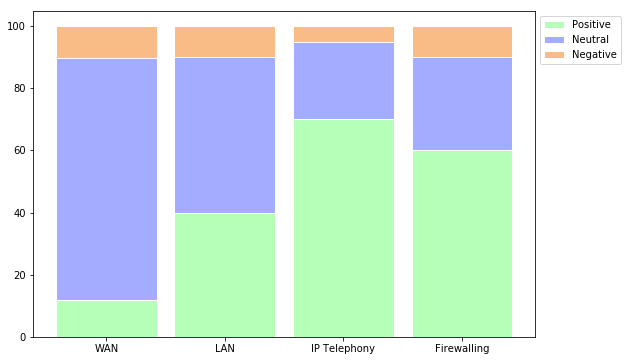

Sentiment Analyser percentages


,topic,positive,negative,neutral
0,WAN,577,498,3785
1,LAN,40,10,50
2,IP Telephony,70,5,25
3,Firewalling,60,10,30


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import pandas as pd
 
# Data
r = [0,1,2,3]
raw_data = {'topic':['WAN','LAN','IP Telephony','Firewalling'] ,'positive': [577, 40, 70, 60], 'negative': [498, 10, 5, 10],'neutral': [3785, 50, 25, 30]}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['positive'], df['negative'], df['neutral'])]
positive = [i / j * 100 for i,j in zip(df['positive'], totals)]
negative = [i / j * 100 for i,j in zip(df['negative'], totals)]
neutral = [i / j * 100 for i,j in zip(df['neutral'], totals)]
 
print("\n SENTIMENT VISUALIZATION")
plt.figure(figsize=(9,6))
# plot
barWidth = 0.85
names = ('WAN','LAN','IP Telephony','Firewalling')
# Create green Bars
plt.bar(r, positive, color='#b5ffb9', edgecolor='white', width=barWidth, label="Positive")
# Create orange Bars
plt.bar(r, neutral, bottom=positive, color='#a3acff', edgecolor='white', width=barWidth, label="Neutral")
# Create blue Bars
plt.bar(r, negative, bottom=[i+j for i,j in zip(positive, neutral)], color='#f9bc86', edgecolor='white', width=barWidth, label="Negative")
 
# Custom x axis
plt.xticks(r, names)

 
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
 
# Show graphic

plt.show()

print("Sentiment Analyser percentages")

df.head()


In [17]:
f = open("preds.pkl", "rb")
#pickle.dump(t,f,pickle.HIGHEST_PROTOCOL)

In [1]:
import pickle

In [18]:
t  = pickle.load(f)

In [66]:
len(t)

4860

In [20]:
t[3]

0.9656236030340993

In [32]:
len([i for i in t if i < 0.89 and i>0.5])

3785

In [24]:
t = [i*0.9 for i in t]